### Osceola JFSP initial output and analysis
-Daymet climate <p>
-Raws station fire weather (clipped to severe events for 'extreme') <p>
-Managment implementations (Swamp buffer thinning)

#### Load required packages and utilities

In [73]:
# Notebook magics
%matplotlib inline

# Dependencies and helper functions
from NECN_utils import *
import os, glob
from IPython.display import Image

# Data directory
dataDir = 'Y:/DanK/Osceola/SimulationOutput/'

In [262]:
def biomassStack(rasterLoc):
    rasterlist = []
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/' + 'biomass/'
        biomap = 'bio-TotalBiomass-' + str(100) + '.img'
        src_ds = gdal.Open( wkDir_data + biomap ) 
        bioarray = src_ds.ReadAsArray()
        bioarray = bioarray.astype('float')
        rasterlist.append(bioarray)
            
    return rasterlist


def biomassGen(rasterList):
    rasterAdj = np.dstack(rasterList)  
    rasterAdj[rasterAdj <= 0] = np.nan
    meanBio = np.nanmean(rasterAdj, axis = 2)
    varBio = np.nanvar(rasterAdj, axis = 2)
    return meanBio, varBio

def genThinLog(simDir, simNames, tlogName):
    counter = 0
    for sim in simNames:        
        repnames = next(os.walk(simDir + sim))[1]
        num_replicates = len(repnames)
        print simDir + sim 
        for rep in repnames:
            thinDir = simDir + sim + '/' + rep + '/Thin/'
            if counter == 0:
                tlogTot = pd.read_csv(thinDir + tlogName)
                tlogTot['SIM'] = sim
                tlogTot['REP'] = rep
            else:           
                tlog = pd.read_csv(thinDir + tlogName)
                tlog['SIM'] = sim
                tlog['REP'] = rep
                tlogTot = pd.concat([tlogTot, tlog])
            counter = counter + 1
    return tlogTot

#### Create a quick list of the directories that hold simulation data
These are fully qualified folder locations

In [75]:
noManagement     = []
TrtmntPlacementN = []
TrtmntPlacementH = []

for sim in glob.glob(dataDir + '*_Noman*'):
    noManagement.append(sim)

for sim in glob.glob(dataDir + '*_TrtmntPlacement_N*'):
    TrtmntPlacementN.append(sim)
    
for sim in glob.glob(dataDir + '*_TrtmntPlacement_H*'):
    TrtmntPlacementH.append(sim)

In [76]:
TrtmntPlacementN

['Y:/DanK/Osceola/SimulationOutput\\Osceola_TrtmntPlacement_N_Contemporary',
 'Y:/DanK/Osceola/SimulationOutput\\Osceola_TrtmntPlacement_N_Extreme']

#### Make use of the LANDIS NECN utilities script
cenOutputGen and genCentWeightedMeansDF are the meat and potatoes of the code that turns a bunch of replicate simulations into an assortment of dataframes that can be used to ask questions about the collection of model results.

In [77]:
nomanContemp, nomanContemp_m = centOutputGen(dataDir, noManagement[0].split('\\')[1])
nomanExtreme, nomanExtreme_m = centOutputGen(dataDir, noManagement[1].split('\\')[1])

trtmntNContemp, trtmntNContemp_m = centOutputGen(dataDir, TrtmntPlacementN[0].split('\\')[1])
trtmntNExtreme, trtmntNExtreme_m = centOutputGen(dataDir, TrtmntPlacementN[1].split('\\')[1])

trtmntHContemp, trtmntHContemp_m = centOutputGen(dataDir, TrtmntPlacementH[1].split('\\')[1])
trtmntHExtreme, trtmntHExtreme_m = centOutputGen(dataDir, TrtmntPlacementH[0].split('\\')[1])

nomanC_w, nomanC_sims, nomanC_summed = genCentWeightedMeansDF(nomanContemp, 'nomanC')
nomanE_w, nomanE_sims, nomanE_summed = genCentWeightedMeansDF(nomanExtreme, 'nomanE')

trtmntNC_w, trtmntNC_sims, trtmntNC_summed = genCentWeightedMeansDF(trtmntNContemp, 'trtmntNC')
trtmntNE_w, trtmntNE_sims, trtmntNE_summed = genCentWeightedMeansDF(trtmntNExtreme, 'trtmntNE')

trtmntHC_w, trtmntHC_sims, trtmntHC_summed = genCentWeightedMeansDF(trtmntHContemp, 'trtmntHC')
trtmntHE_w, trtmntHE_sims, trtmntHE_summed = genCentWeightedMeansDF(trtmntHExtreme, 'trtmntHE')

totSimsNoMan = pd.concat([nomanC_w, nomanE_w])
totSimsAllNoMan =  pd.concat([nomanC_sims, nomanE_sims])

totSimsTrtmntN = pd.concat([trtmntNC_w, trtmntNE_w])
totSimsAllTrtmntN =  pd.concat([trtmntNC_sims, trtmntNE_sims])

totSimsTrtmntH = pd.concat([trtmntHC_w, trtmntHE_w])
totSimsAllTrtmntH =  pd.concat([trtmntHC_sims, trtmntHE_sims])

totSimsAllNoMan['Trtmnt'] = 'No Management'
totSimsAllNoMan['FW']     = 'Contemporary'
totSimsAllNoMan.FW[totSimsAllNoMan.Sim == 'nomanE'] = 'Extreme'

totSimsAllTrtmntN['Trtmnt'] = 'Treatment Placement'
totSimsAllTrtmntN['FW']     = 'Contemporary'
totSimsAllTrtmntN.FW[totSimsAllTrtmntN.Sim == 'trtmntNE'] = 'Extreme'

totSimsAllTrtmntH['Trtmnt'] = 'Treatment Placement and Harvest'
totSimsAllTrtmntH['FW']     = 'Contemporary'
totSimsAllTrtmntH.FW[totSimsAllTrtmntH.Sim == 'trtmntHE'] = 'Extreme'

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Carbon accumulation results

#### Plot the max, mean, 5th percentile, and minimum of AGC
across the collection of simulation replicates. 

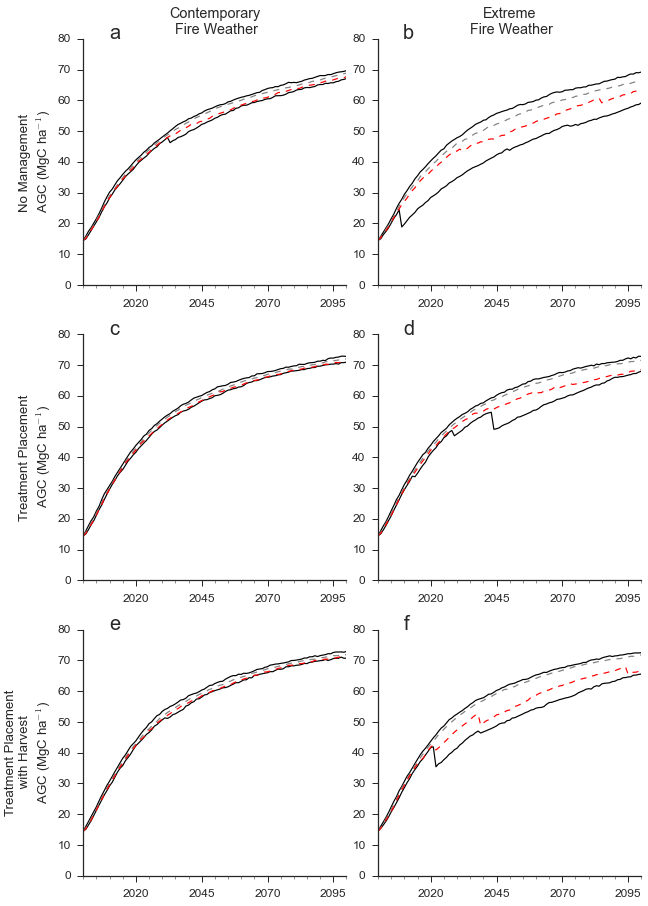

In [219]:
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(10,15))
plt.subplots_adjust(wspace = 0.12)


plotAllSimsMinMaxMed(totSimsAllNoMan[totSimsAllNoMan.Sim == 'nomanC'], 
                     'AGBw', 'No Management', ax = ax1)
plotAllSimsMinMaxMed(totSimsAllNoMan[totSimsAllNoMan.Sim == 'nomanE'], 
                     'AGBw', 'No Management', ax = ax2)

plotAllSimsMinMaxMed(totSimsAllTrtmntN[totSimsAllTrtmntN.Sim == 'trtmntNC'], 
                     'AGBw', 'Treatment Placement', ax = ax3)
plotAllSimsMinMaxMed(totSimsAllTrtmntN[totSimsAllTrtmntN.Sim == 'trtmntNE'], 
                     'AGBw', 'Treatment Placement', ax = ax4)

plotAllSimsMinMaxMed(totSimsAllTrtmntH[totSimsAllTrtmntH.Sim == 'trtmntHC'], 
                     'AGBw', 'Treatment Placement and Harvest', ax = ax5)
plotAllSimsMinMaxMed(totSimsAllTrtmntH[totSimsAllTrtmntH.Sim == 'trtmntHE'], 
                     'AGBw', 'Treatment Placement and Harvest', ax = ax6)

ax1.set_ylabel('AGC')
ax1.set_title('Contemporary\n Fire Weather')
ax2.set_title('Extreme\n Fire Weather')
ax1.set_ylabel('No Management\n AGC (MgC ha$^{-1}$)')
ax3.set_ylabel('Treatment Placement\n AGC (MgC ha$^{-1}$)')
ax5.set_ylabel('Treatment Placement\n with Harvest\n AGC (MgC ha$^{-1}$)')


for ax in f.axes:
    ax.set_ylim([0,80])
    
ax1.text(40, 80, 'a',  fontsize=20)
ax2.text(40, 80, 'b',  fontsize=20)
ax3.text(40, 80, 'c', fontsize=20)
ax4.text(40, 80, 'd', fontsize=20)
ax5.text(40, 80, 'e', fontsize=20)
ax6.text(40, 80, 'f', fontsize=20)

sns.despine()
plt.savefig('AGC.tif')

### Dig into the AGC dataframe and get out some specifics for the MS

In [237]:
NoManC50S = totSimsAllNoMan[(totSimsAllNoMan.Time == 50) & (totSimsAllNoMan.Sim == 'nomanC')]
NoManC50S = NoManC50S.groupby('rep').sum()
NoManC50S.AGBw.describe()

count    30.000000
mean     56.985322
std       0.865365
min      54.186554
25%      56.704458
50%      57.213209
75%      57.531570
max      57.886924
Name: AGBw, dtype: float64

In [238]:
NoManC100S = totSimsAllNoMan[(totSimsAllNoMan.Time == 100) & (totSimsAllNoMan.Sim == 'nomanC')]
NoManC100S = NoManC100S.groupby('rep').sum()
NoManC100S.AGBw.describe()

count    30.000000
mean     68.771207
std       0.583511
min      67.060910
25%      68.476720
50%      68.865103
75%      69.174872
max      69.671643
Name: AGBw, dtype: float64

In [241]:
TreatmentNC100S = totSimsAllTrtmntN[(totSimsAllTrtmntN.Time == 100) & (totSimsAllTrtmntN.Sim == 'trtmntNC')]
TreatmentNC100S = TreatmentNC100S.groupby('rep').sum()
TreatmentNC100S.AGBw.describe()

count    30.000000
mean     71.957589
std       0.491111
min      70.944691
25%      71.635632
50%      71.988300
75%      72.311868
max      72.761420
Name: AGBw, dtype: float64

In [243]:
TreatmentHC100S = totSimsAllTrtmntH[(totSimsAllTrtmntH.Time == 100) & (totSimsAllTrtmntH.Sim == 'trtmntHC')]
TreatmentHC100S = TreatmentHC100S.groupby('rep').sum()
TreatmentHC100S.AGBw.describe()

count    30.000000
mean     71.947143
std       0.426470
min      70.723633
25%      71.721223
50%      71.933702
75%      72.106904
max      72.924179
Name: AGBw, dtype: float64

### ExtremeFW

In [244]:
NoManE100S = totSimsAllNoMan[(totSimsAllNoMan.Time == 100) & (totSimsAllNoMan.Sim == 'nomanE')]
NoManE100S = NoManE100S.groupby('rep').sum()
NoManE100S.AGBw.describe()

count    29.000000
mean     66.295082
std       2.001610
min      59.160686
25%      65.707865
50%      66.391108
75%      67.175865
max      69.205967
Name: AGBw, dtype: float64

In [245]:
TreatmentNC100S = totSimsAllTrtmntN[(totSimsAllTrtmntN.Time == 100) & (totSimsAllTrtmntN.Sim == 'trtmntNC')]
TreatmentNC100S = TreatmentNC100S.groupby('rep').sum()
TreatmentNC100S.AGBw.describe()

count    30.000000
mean     71.957589
std       0.491111
min      70.944691
25%      71.635632
50%      71.988300
75%      72.311868
max      72.761420
Name: AGBw, dtype: float64

In [246]:
TreatmentHC100S = totSimsAllTrtmntH[(totSimsAllTrtmntH.Time == 100) & (totSimsAllTrtmntH.Sim == 'trtmntHC')]
TreatmentHC100S = TreatmentHC100S.groupby('rep').sum()
TreatmentHC100S.AGBw.describe()

count    30.000000
mean     71.947143
std       0.426470
min      70.723633
25%      71.721223
50%      71.933702
75%      72.106904
max      72.924179
Name: AGBw, dtype: float64

### Wildfire results

#### Generate the wildfire severity maps
This includes mean and variance rasters

In [79]:
sevmaps_mu = []
sevmaps_var = []

for sim in noManagement:
    print sim
    
    sevrasters = severityStack(sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevmaps_mu.append(sevmap)
    sevmaps_var.append(sevVarmap)

Y:/DanK/Osceola/SimulationOutput\Osceola_Noman_Contemporary
Y:/DanK/Osceola/SimulationOutput\Osceola_Noman_Extreme


In [80]:
sevmapsH_mu = []
sevmapsH_var = []

for sim in TrtmntPlacementH:
    print sim
    
    sevrasters = severityStack(sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevmapsH_mu.append(sevmap)
    sevmapsH_var.append(sevVarmap)

Y:/DanK/Osceola/SimulationOutput\Osceola_TrtmntPlacement_H_Extreme
Y:/DanK/Osceola/SimulationOutput\Osceola_TrtmntPlacement_H_Contemporary


In [81]:
sevmapsN_mu = []
sevmapsN_var = []

for sim in TrtmntPlacementN:
    print sim
    
    sevrasters = severityStack(sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevmapsN_mu.append(sevmap)
    sevmapsN_var.append(sevVarmap)
    



Y:/DanK/Osceola/SimulationOutput\Osceola_TrtmntPlacement_N_Contemporary
Y:/DanK/Osceola/SimulationOutput\Osceola_TrtmntPlacement_N_Extreme


#### Plot the mean wildfire severity maps for the Osceola

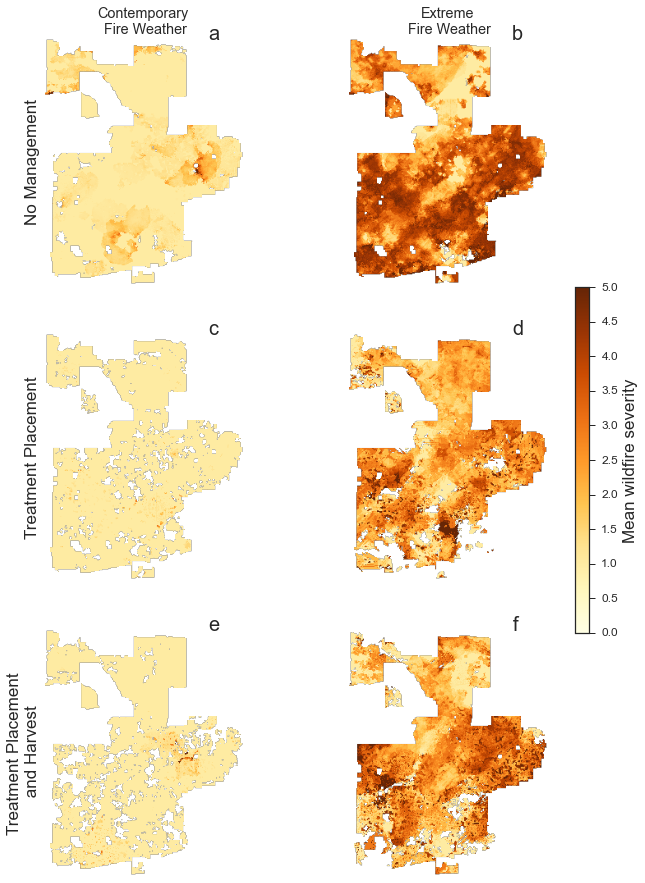

In [162]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(10,15))

axs = f.axes
sns.despine()
idx = 0

ax1.imshow(sevmaps_mu[0][noManagement[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax2.imshow(sevmaps_mu[1][noManagement[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax1.set_title('Contemporary\n Fire Weather')
ax2.set_title('Extreme\n Fire Weather')
ax1.set_ylabel('No Management', fontsize = 17)

ax3.imshow(sevmapsN_mu[0][TrtmntPlacementN[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax4.imshow(sevmapsN_mu[1][TrtmntPlacementN[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax3.set_ylabel('Treatment Placement', fontsize = 17)

ax5.imshow(sevmapsH_mu[1][TrtmntPlacementH[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax6.imshow(sevmapsH_mu[0][TrtmntPlacementH[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax5.set_ylabel('Treatment Placement\n and Harvest', fontsize = 17)

for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([.90, 0.35, 0.02, 0.32])

ax1.text(200, 0, 'a',  fontsize=20)
ax2.text(200, 0, 'b',  fontsize=20)
ax3.text(200, 0, 'c', fontsize=20)
ax4.text(200, 0, 'd', fontsize=20)
ax5.text(200, 0, 'e', fontsize=20)
ax6.text(200, 0, 'f', fontsize=20)

kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Mean wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(17)
plt.savefig('FireSev.tif')

### Look at reduction in mean fire severity


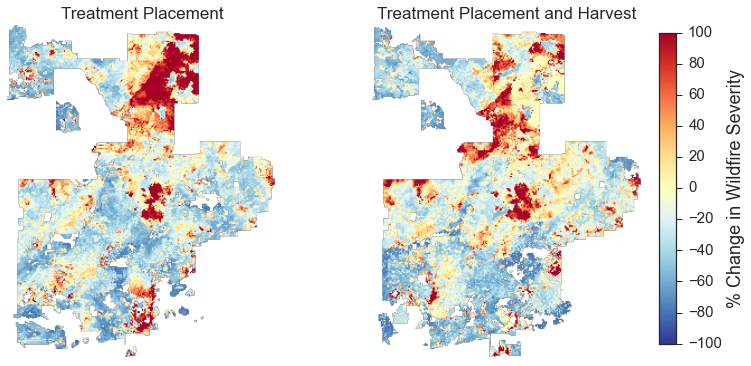

In [201]:
f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,6))
sns.despine()

noH_Diff = (sevmapsN_mu[1][TrtmntPlacementN[1]] - sevmaps_mu[1][noManagement[1]]) / (sevmaps_mu[1][noManagement[1]])*100
H_Diff = (sevmapsH_mu[0][TrtmntPlacementH[0]] - sevmaps_mu[1][noManagement[1]]) / (sevmaps_mu[1][noManagement[1]])*100

cbarmap = ax1.imshow(noH_Diff, cmap = 'RdYlBu_r', vmin =-100, vmax = 100)
cbarmap = ax2.imshow(H_Diff, cmap = 'RdYlBu_r', vmin =-100, vmax = 100)

ax1.set_title('Treatment Placement', fontsize = 17)
ax2.set_title('Treatment Placement and Harvest', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([.90, 0.16, 0.02, 0.72])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = '% Change in Wildfire Severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)
plt.savefig('PercentChangeSev.tif')

#### Plot the variance of wildfire severity maps for the Osceola

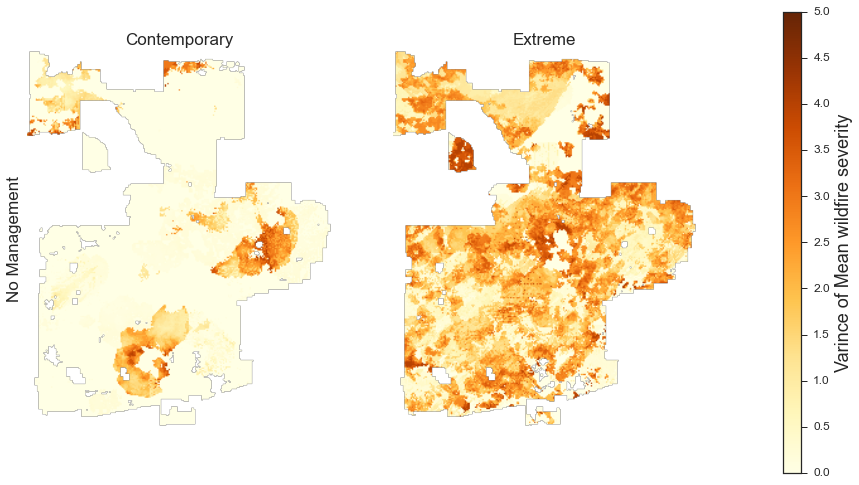

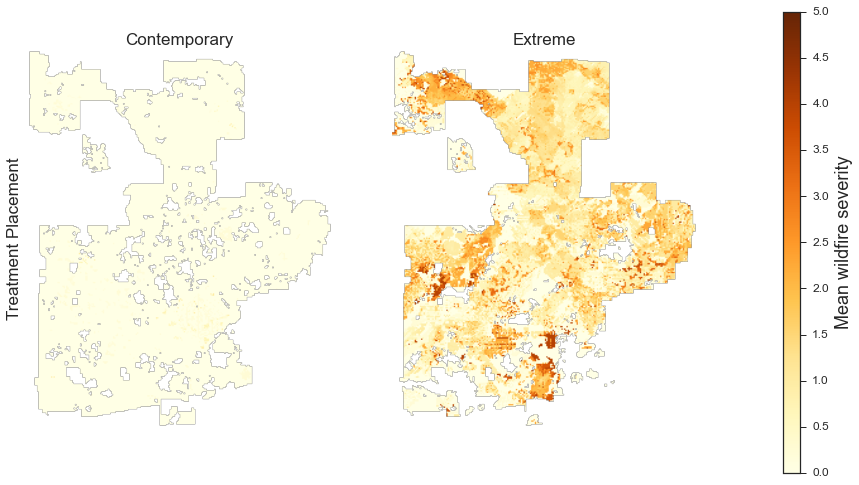

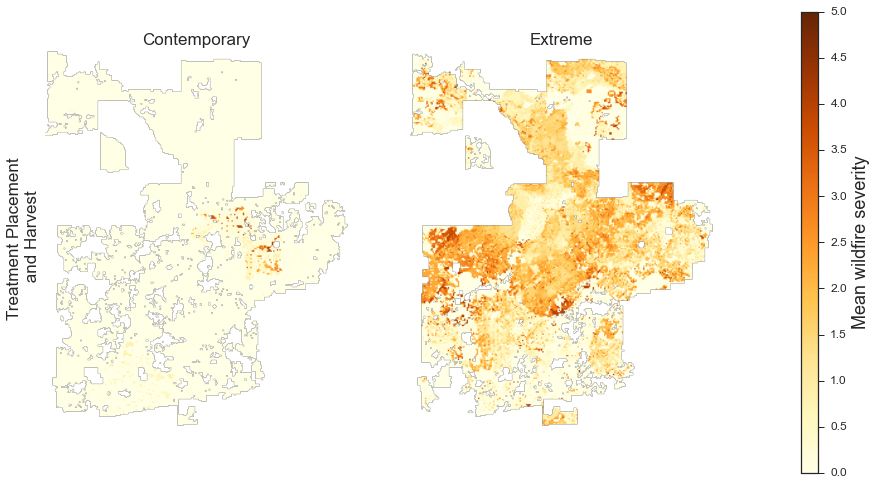

In [131]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(10,15))

axs = f.axes
sns.despine()
idx = 0

ax1.imshow(sevmaps_var[0][noManagement[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax2.imshow(sevmaps_var[1][noManagement[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax1.set_title('Contemporary', fontsize = 17)
ax2.set_title('Extreme', fontsize = 17)
ax1.set_ylabel('No Management', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([1, 0.35, 0.02, 0.32])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Varince of wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)

f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,20))
#plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(sevmapsN_var[0][TrtmntPlacementN[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax2.imshow(sevmapsN_var[1][TrtmntPlacementN[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax1.set_title('Contemporary', fontsize = 17)
ax2.set_title('Extreme', fontsize = 17)
ax1.set_ylabel('Treatment Placement', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([1, 0.35, 0.02, 0.32])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Varince of wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)

f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,20))
#plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(sevmapsH_var[1][TrtmntPlacementH[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
cbarmap = ax2.imshow(sevmapsH_var[0][TrtmntPlacementH[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
ax1.set_title('Contemporary', fontsize = 17)
ax2.set_title('Extreme', fontsize = 17)
ax1.set_ylabel('Treatment Placement\n and Harvest', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([1, 0.35, 0.02, 0.32])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Varince of wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)

### Fire severity and variance of severity raster calculations

In [209]:
print np.nanmean(sevmaps_mu[0][noManagement[0]])
print np.nanmean(sevmaps_mu[1][noManagement[1]])
print np.nanmean(sevmapsN_mu[0][TrtmntPlacementN[0]])
print np.nanmean(sevmapsN_mu[1][TrtmntPlacementN[1]])
print np.nanmean(sevmapsH_mu[1][TrtmntPlacementH[1]])
print np.nanmean(sevmapsH_mu[0][TrtmntPlacementH[0]])


1.16019612694
3.05522701367
1.01368626218
2.3903056451
1.03624569145
2.49496964981


In [216]:
print np.nanmean(sevmaps_var[0][noManagement[0]])
print np.nanmean(sevmaps_var[1][noManagement[1]])
print np.nanmean(sevmapsN_var[0][TrtmntPlacementN[0]])
print np.nanmean(sevmapsN_var[1][TrtmntPlacementN[1]])
print np.nanmean(sevmapsH_var[1][TrtmntPlacementH[1]])
print np.nanmean(sevmapsH_var[0][TrtmntPlacementH[0]])


0.329225429309
1.52490293399
0.00758896578637
0.949197994076
0.0375515994255
1.00085296476


In [215]:
print (2.3903056451 - 3.05522701367) / 3.05522701367
print (2.49496964981 - 3.05522701367) / 3.05522701367

-0.217634030334
-0.183376672618


In [217]:
print (0.949197994076 - 1.52490293399) / 1.52490293399
print (1.00085296476 - 1.52490293399) / 1.52490293399

-0.377535466082
-0.343661198066


### Quickly looking into the cumulative fire emissions

In [85]:
nomansum = totSimsAllNoMan.groupby(['Sim','Trtmnt','rep']).sum().reset_index()
nomanmean = nomansum.groupby(['Sim','Trtmnt']).mean()

Rxsum = totSimsAllTrtmntN.groupby(['Sim','Trtmnt','rep']).sum().reset_index()
Rxmean = Rxsum.groupby(['Sim','Trtmnt']).mean()

RxHsum = totSimsAllTrtmntH.groupby(['Sim','Trtmnt','rep']).sum().reset_index()
RxHmean = RxHsum.groupby(['Sim','Trtmnt']).mean()


nomanmean

,,rep,Time,EcoregionIndex,NumSites,NEEC,SOMTC,AGB,AG_NPPC,BG_NPPC,Litterfall,...,Nvol,FrassC,TEC,AGBc,NECB,TECw,AGBw,NEECw,FireCEffluxw,NECBw
Sim,Trtmnt,,,,,,,,,,,,,,,,,,,,,
nomanC,No Management,15.500000,10100.0,303.0,4118780.0,208.142533,1.068472e+06,1.937653e+06,66836.536667,19466.970000,28969.77000,...,109.207333,0.0,20372.979800,9688.263000,207.93960,10859.960834,5262.583105,110.191501,0.110170,110.081330
nomanE,No Management,15.344828,10100.0,303.0,4118780.0,207.819862,1.041115e+06,1.856897e+06,65239.400000,19007.296552,28347.12069,...,110.126207,0.0,19695.631328,9284.484086,206.54369,10467.798300,5028.710236,110.048827,0.728035,109.320792


In [86]:

biomaps_mu = []
biomaps_var = []

for sim in noManagement:
    print sim
    
    biorasters = biomassStack(sim)
    bioMap, bioVarMap = biomassGen(biorasters)
    biomap = {sim : bioMap}
    bioVarmap = {sim : bioVarMap}

    biomaps_mu.append(biomap)
    biomaps_var.append(bioVarmap)
    
biomapsH_mu = []
biomapsH_var = []

for sim in TrtmntPlacementH:
    print sim
    
    biorasters = biomassStack(sim)
    bioMap, bioVarMap = biomassGen(biorasters)
    biomap = {sim : bioMap}
    bioVarmap = {sim : bioVarMap}

    biomapsH_mu.append(biomap)
    biomapsH_var.append(bioVarmap)
    
biomapsN_mu = []
biomapsN_var = []

for sim in TrtmntPlacementN:
    print sim
    
    biorasters = biomassStack(sim)
    bioMap, bioVarMap = biomassGen(biorasters)
    biomap = {sim : bioMap}
    bioVarmap = {sim : bioVarMap}

    biomapsN_mu.append(biomap)
    biomapsN_var.append(bioVarmap)

Y:/DanK/Osceola/SimulationOutput\Osceola_Noman_Contemporary
Y:/DanK/Osceola/SimulationOutput\Osceola_Noman_Extreme
Y:/DanK/Osceola/SimulationOutput\Osceola_TrtmntPlacement_H_Extreme
Y:/DanK/Osceola/SimulationOutput\Osceola_TrtmntPlacement_H_Contemporary
Y:/DanK/Osceola/SimulationOutput\Osceola_TrtmntPlacement_N_Contemporary
Y:/DanK/Osceola/SimulationOutput\Osceola_TrtmntPlacement_N_Extreme


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:24: RuntimeWarning: Mean of empty slice
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice.


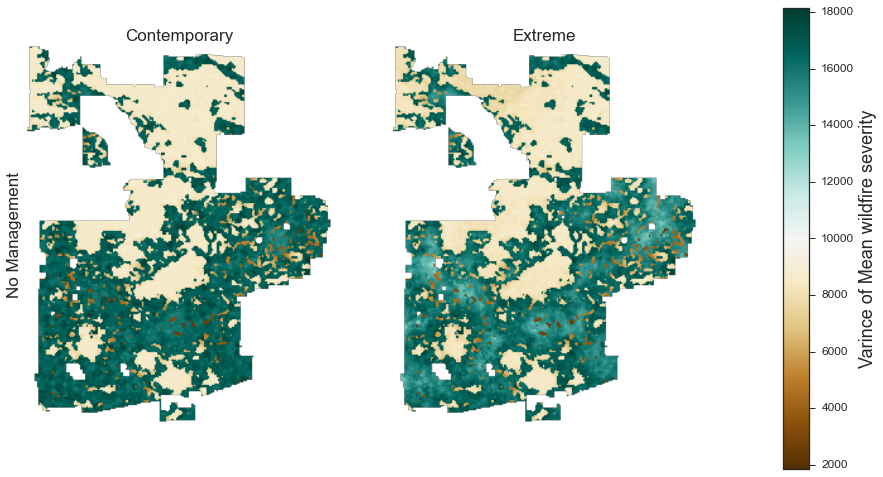

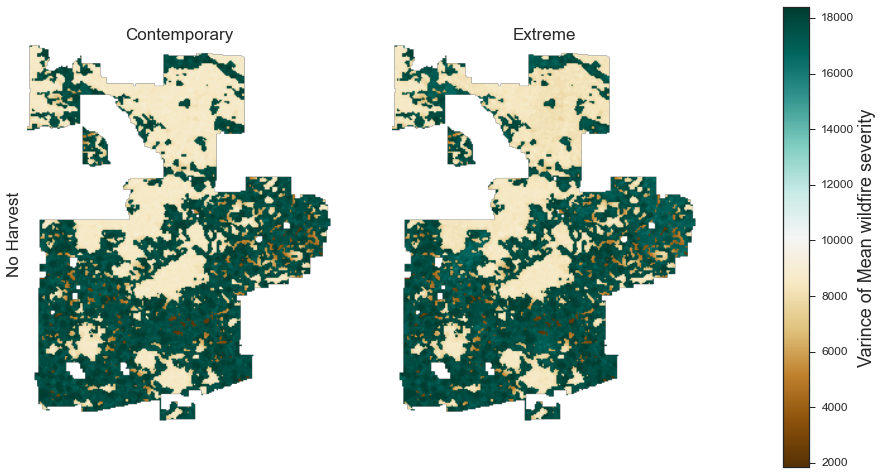

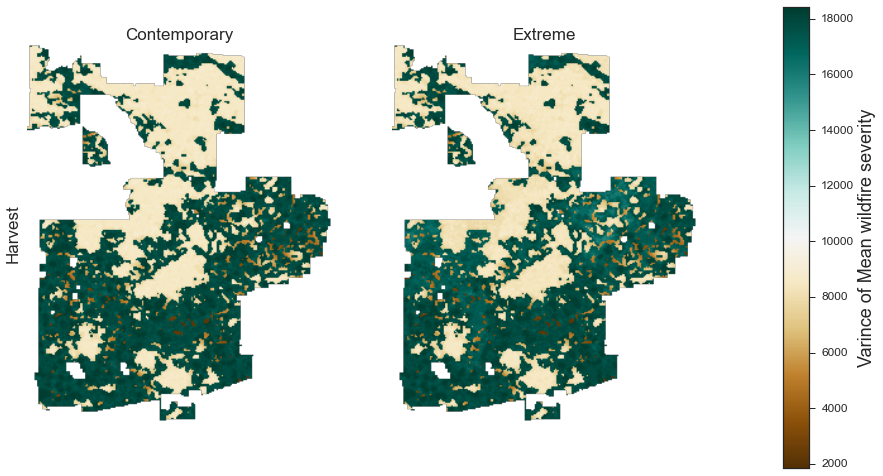

In [87]:
f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,20))
#plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(biomaps_mu[0][noManagement[0]], cmap = 'BrBG')
cbarmap = ax2.imshow(biomaps_mu[1][noManagement[1]], cmap = 'BrBG')
ax1.set_title('Contemporary', fontsize = 17)
ax2.set_title('Extreme', fontsize = 17)
ax1.set_ylabel('No Management', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([1, 0.35, 0.03, 0.32])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Varince of Mean wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)


f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,20))
#plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(biomapsN_mu[0][TrtmntPlacementN[0]], cmap = 'BrBG')
cbarmap = ax2.imshow(biomapsN_mu[1][TrtmntPlacementN[1]], cmap = 'BrBG')
ax1.set_title('Contemporary', fontsize = 17)
ax2.set_title('Extreme', fontsize = 17)
ax1.set_ylabel('No Harvest', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([1, 0.35, 0.03, 0.32])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Varince of Mean wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)


f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,20))
#plt.subplots_adjust(wspace = -.5, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(biomapsH_mu[1][TrtmntPlacementH[1]], cmap = 'BrBG')
cbarmap = ax2.imshow(biomapsH_mu[0][TrtmntPlacementH[0]], cmap = 'BrBG')
ax1.set_title('Contemporary', fontsize = 17)
ax2.set_title('Extreme', fontsize = 17)
ax1.set_ylabel('Harvest', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([1, 0.35, 0.03, 0.32])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = 'Varince of Mean wildfire severity')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)


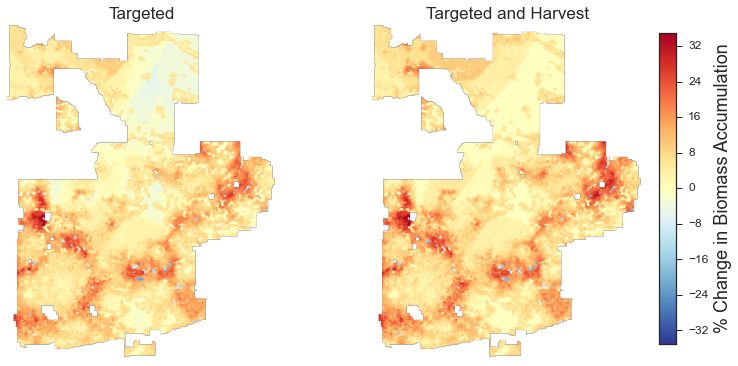

In [284]:
f, (ax1, ax2) = plt.subplots(1,2, figsize =(12,6))
sns.despine()

noH_Diff = (biomapsN_mu[1][TrtmntPlacementN[1]] - biomaps_mu[1][noManagement[1]]) / (biomaps_mu[1][noManagement[1]])*100
H_Diff = (biomapsH_mu[1][TrtmntPlacementH[1]] - biomaps_mu[1][noManagement[1]]) / (biomaps_mu[1][noManagement[1]])*100

cbarmap = ax1.imshow(noH_Diff, cmap = 'RdYlBu_r', vmin = -35, vmax = 35 )
cbarmap = ax2.imshow(H_Diff, cmap = 'RdYlBu_r', vmin = -35, vmax = 35  )

ax1.set_title('Targeted', fontsize = 17)
ax2.set_title('Targeted and Harvest', fontsize = 17)
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([.90, 0.16, 0.02, 0.72])
kk = f.colorbar(cbarmap, cax=cbar_ax, label = '% Change in Biomass Accumulation')
axCB = kk.ax
text = axCB.yaxis.label
text.set_fontsize(18)
plt.savefig('PercentChangeBio.tif')

In [258]:
np.nanmean(H_Diff)

7.3323182035271337

#### Dig into the fire logs
and create plots of cumulative area burned, total area burned, and maybe use the ecoregion raster and the mean severity rasters to ask questions about the distribution of fire across the landscape. I don't have any functions written to handle this quickly, so I'll define them here and move them into the utils script later on.

In [174]:
allSims = [noManagement[0],
TrtmntPlacementN[0],
TrtmntPlacementH[0],
noManagement[1],
TrtmntPlacementN[1],
TrtmntPlacementH[1]
]

In [175]:
DFFSlog = 'dynamic-fire-test-log.csv'
idx = 0

noManagement
TrtmntPlacementN
TrtmntPlacementH

for sim in allSims:
    repnames = next(os.walk(sim))[1]
    num_replicates = len(repnames)
    for rep in repnames:
        repnum = rep.split('replicate')[1]
        
        if idx == 0:
            flog = pd.read_csv(sim + '/' 'replicate' + \
                               repnum + '/' + DFFSlog)
            flog['rep'] = repnum
            flog['sim'] = sim.split('\\')[1]
            idx += 1
        else:
            nextflog = pd.read_csv(sim + '/' 'replicate' + \
                                   repnum + '/' + DFFSlog)
            nextflog['rep'] = repnum
            nextflog['sim'] = sim.split('\\')[1]
            flog = pd.concat([flog,  nextflog])
            idx += 1

### In the Osceola simulation environment, each pixel is 150 x 150 m
That means each pixel is 2.25 ha. So, most of the calculations are scaling square meters to ha, and the pixel reference is implicitly handled by the model (as is the case in the Century calculations). However, the fire logs refer to total Sites in the event, which to me means number of pixels. That means we need to calculate the area of the total sites by 2.25 to get to ha correctly.

In [193]:
sumFiresByRep = flog.groupby(['rep', 'sim']).sum().reset_index()
sumFiresByRep['Management'] = 'No Management'
sumFiresByRep['FW'] = 'Contemporary'

sumFiresByRep.Management[sumFiresByRep.sim == 'Osceola_TrtmntPlacement_H_Contemporary'] = 'Treatment Placement\n with Harvest'
sumFiresByRep.Management[sumFiresByRep.sim == 'Osceola_TrtmntPlacement_N_Contemporary'] = 'Treatment Placement'
sumFiresByRep.Management[sumFiresByRep.sim == 'Osceola_TrtmntPlacement_H_Extreme'] = 'Treatment Placement\n with Harvest'
sumFiresByRep.Management[sumFiresByRep.sim == 'Osceola_TrtmntPlacement_N_Extreme'] = 'Treatment Placement'

sumFiresByRep.FW[sumFiresByRep.sim == 'Osceola_TrtmntPlacement_H_Extreme'] = 'Extreme'
sumFiresByRep.FW[sumFiresByRep.sim == 'Osceola_TrtmntPlacement_N_Extreme'] = 'Extreme'
sumFiresByRep.FW[sumFiresByRep.sim == 'Osceola_Noman_Extreme'] = 'Extreme'

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

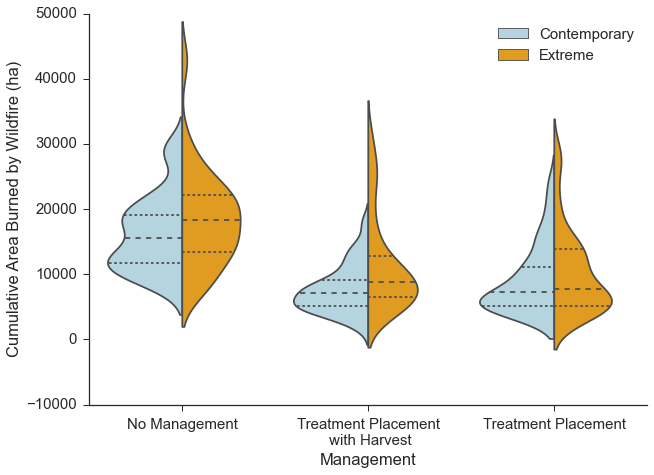

In [195]:
sumFiresByRep['AreaInHa'] = sumFiresByRep.TotalSitesInEvent * 2.25
sns.set_context('notebook', font_scale=1.5)
f, (ax1) = plt.subplots(1,1, figsize =(10,7))

sns.violinplot(y = 'AreaInHa', x = 'Management', 
               hue = 'FW', inner = 'quartile',
               palette = ['lightblue','orange'],
               data = sumFiresByRep, split = True, bw=.4,
               ax = ax1)
ax1.legend(loc = 1)
ax1.set_ylabel('Cumulative Area Burned by Wildfire (ha)')
sns.despine()
plt.savefig('CumulativeAreaBurned.tif')

In [261]:
sumFiresByRep.groupby(['sim','FW']).describe()

AreaInHa                \
                                                       count          mean   
sim                                    FW                                    
Osceola_Noman_Contemporary             Contemporary     30.0  16286.775000   
Osceola_Noman_Extreme                  Extreme          29.0  18320.741379   
Osceola_TrtmntPlacement_H_Contemporary Contemporary     30.0   7691.700000   
Osceola_TrtmntPlacement_H_Extreme      Extreme          27.0  11413.000000   
Osceola_TrtmntPlacement_N_Contemporary Contemporary     30.0   9171.075000   
Osceola_TrtmntPlacement_N_Extreme      Extreme          30.0  10269.450000   

                                                                           \
                                                             std      min   
sim                                    FW                                   
Osceola_Noman_Contemporary             Contemporary  5923.295910  8511.75   
Osceola_Noman_Extreme                  Extreme       7479.806782  7899.75   
Osceola_TrtmntPlacement_H_Contemporary Contemporary  3702.185832  2088.00   
Osceola_TrtmntPlacement_H_Extreme      Extreme       7315.827814  4587.75   
Osceola_TrtmntPlacement_N_Contemporary Contemporary  5291.717769  4299.75   
Osceola_TrtmntPlacement_N_Extreme      Extreme       6572.079417  3692.25   

                                                                            \
                                                            25%        50%   
sim                                    FW                                    
Osceola_Noman_Contemporary             Contemporary  11733.7500  15598.125   
Osceola_Noman_Extreme                  Extreme       13394.2500  18366.750   
Osceola_TrtmntPlacement_H_Contemporary Contemporary   5083.8750   7177.500   
Osceola_TrtmntPlacement_H_Extreme      Extreme        6460.8750   8775.000   
Osceola_TrtmntPlacement_N_Contemporary Contemporary   5135.6250   7221.375   
Osceola_TrtmntPlacement_N_Extreme      Extreme        5176.6875   7692.750   

                                                                           \
                                                            75%       max   
sim                                    FW                                   
Osceola_Noman_Contemporary             Contemporary  19087.8750  29394.00   
Osceola_Noman_Extreme                  Extreme       22203.0000  42783.75   
Osceola_TrtmntPlacement_H_Contemporary Contemporary   9143.4375  17878.50   
Osceola_TrtmntPlacement_H_Extreme      Extreme       12876.7500  30764.25   
Osceola_TrtmntPlacement_N_Contemporary Contemporary  11197.6875  24041.25   
Osceola_TrtmntPlacement_N_Extreme      Extreme       13855.5000  28563.75   

                                                      BUI                \
                                                    count          mean   
sim                                    FW                                 
Osceola_Noman_Contemporary             Contemporary  30.0   6140.500000   
Osceola_Noman_Extreme                  Extreme       29.0  11067.724138   
Osceola_TrtmntPlacement_H_Contemporary Contemporary  30.0   3333.633333   
Osceola_TrtmntPlacement_H_Extreme      Extreme       27.0   6439.111111   
Osceola_TrtmntPlacement_N_Contemporary Contemporary  30.0   3349.566667   
Osceola_TrtmntPlacement_N_Extreme      Extreme       30.0   5711.866667   

                                                      ...      eco-1           \
                                                      ...        75%      max   
sim                                    FW             ...                       
Osceola_Noman_Contemporary             Contemporary   ...    6338.25   9231.0   
Osceola_Noman_Extreme                  Extreme        ...    6086.00  14446.0   
Osceola_TrtmntPlacement_H_Contemporary Contemporary   ...       0.00      0.0   
Osceola_TrtmntPlacement_H_Extreme      Extreme        ...       0.00      0.0   
Osceola_TrtmntP

### Wildfire emissions as  function of management
One of the targets for this research is to determine the quantity of C emitted as a function of wildfire, and prescribed fire (Rx fire). LANDIS-II DFFS handles wildfire X efflux as a native output in the Century NECN extension. However, the Rx fire C emissions are less straight forward, and parsing where those emissions come from is again not very simple. 

The goal here is to produce a total C lost curve, which will include wildfire C efflux and treatment (Rx + thinning) C efflux. Along the way we will group the data apropriately to produce box and bar plots that characterize each component of total C efflux separately.

In [286]:
Trtmnt_N_C = genThinLog(dataDir, ['Osceola_TrtmntPlacement_N_Contemporary'], 'log.csv')
Trtmnt_N_C['simname'] = 'Targeted'
Trtmnt_N_C['FW'] = 'Contemporary'

Trtmnt_N_E = genThinLog(dataDir, ['Osceola_TrtmntPlacement_N_Extreme'], 'log.csv')
Trtmnt_N_E['simname'] = 'Targeted'
Trtmnt_N_E['FW'] = 'Extreme'

Trtmnt_H_C = genThinLog(dataDir, ['Osceola_TrtmntPlacement_H_Contemporary'], 'log.csv')
Trtmnt_H_C['simname'] = 'Targeted and Harvest'
Trtmnt_H_C['FW'] = 'Contemporary'
  
Trtmnt_H_E = genThinLog(dataDir, ['Osceola_TrtmntPlacement_H_Extreme'], 'log.csv')
Trtmnt_H_E['simname'] = 'Targeted and Harvest'
Trtmnt_H_E['FW'] = 'Extreme'


Y:/DanK/Osceola/SimulationOutput/Osceola_TrtmntPlacement_N_Contemporary
Y:/DanK/Osceola/SimulationOutput/Osceola_TrtmntPlacement_N_Extreme
Y:/DanK/Osceola/SimulationOutput/Osceola_TrtmntPlacement_H_Contemporary
Y:/DanK/Osceola/SimulationOutput/Osceola_TrtmntPlacement_H_Extreme


In [294]:
summedLogsNC = Trtmnt_N_C.groupby(['SIM','simname','Prescription','FW', 'REP']).sum().reset_index()
summedLogsNE = Trtmnt_N_E.groupby(['SIM','simname','Prescription','FW','REP']).sum().reset_index()
summedLogsHC = Trtmnt_H_C.groupby(['SIM','simname','Prescription','FW','REP']).sum().reset_index()
summedLogsHE = Trtmnt_H_E.groupby(['SIM','simname','Prescription','FW','REP']).sum().reset_index()


In [460]:
timeSum_NC = Trtmnt_N_C.groupby(['FW','simname','REP','SIM','Prescription','Time']).sum().reset_index()
timeSum_NCm = timeSum_NC.groupby(['FW','simname','SIM','Prescription','Time']).mean().reset_index()


In [466]:
timeSum_HC = Trtmnt_H_C.groupby(['FW','simname','REP','SIM','Prescription','Time']).sum().reset_index()
timeSum_HCm = timeSum_HC.groupby(['FW','simname','SIM','Prescription','Time']).mean().reset_index()


### Time series of Treatment Carbon Removed from Contemporary FW, Harvested and No Harvested sims

-
--
-


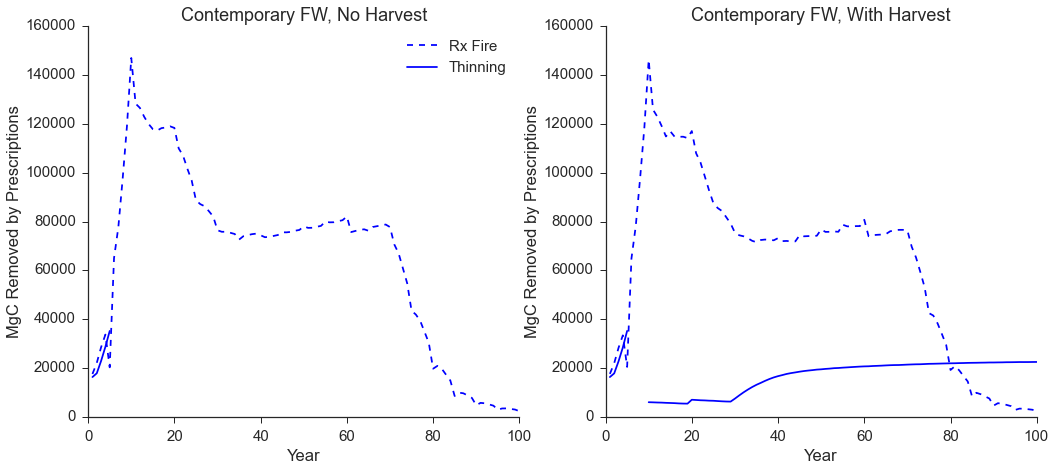

In [520]:
f, (ax1, ax2) = plt.subplots(1,2, figsize =(17,7))
styles = ['--', '-', '.']
colidx = 0
for df in [timeSum_NCm]:
    idx = 0
    for prescrip in np.unique(df.Prescription):
        dfp = df[df.Prescription == prescrip]
        ax1.plot(dfp.Time, dfp.MgBiomassRemoved * 0.5, ls = styles[idx], c = col[colidx])
        idx += 1
    colidx += 1
ax1.set_ylabel('MgC Removed by Prescriptions')
ax1.set_xlabel('Year')


styles = ['-', '--', '-']
colidx = 0
for df in [timeSum_HCm]:
    idx = 0
    for prescrip in np.unique(df.Prescription):
        dfp = df[df.Prescription == prescrip]
        ax2.plot(dfp.Time, dfp.MgBiomassRemoved * 0.5, ls = styles[idx], c = col[colidx])
        print styles[idx]
        idx += 1
    colidx += 1
ax2.set_ylabel('MgC Removed by Prescriptions')
ax2.set_xlabel('Year')

ax1.set_title('Contemporary FW, No Harvest')
ax2.set_title('Contemporary FW, With Harvest')

ax1.legend(['Rx Fire','Thinning' ])

sns.despine()

In [525]:
NMeWF

,rep,FW,Trtmnt,Time,EcoregionIndex,NumSites,NEEC,SOMTC,AGB,AG_NPPC,...,Nvol,FrassC,TEC,AGBc,NECB,TECw,AGBw,NEECw,FireCEffluxw,NECBw
3,1,Extreme,No Management,10100,303,4118780,189.422,935430.8,1571827.1,57716.1,...,116.31,0,17213.4435,7859.1355,186.860,8994.534768,4182.775399,99.167836,1.498882,97.668954
9,2,Extreme,No Management,10100,303,4118780,209.750,1049596.2,1884928.7,65978.3,...,109.74,0,19920.6055,9424.6435,208.584,10597.522784,5106.583035,111.007733,0.681037,110.326696
14,3,Extreme,No Management,10100,303,4118780,205.789,1036286.3,1853173.7,64863.3,...,107.40,0,19628.7315,9265.8685,204.461,10461.490733,5035.300206,109.247721,0.725370,108.522351
18,4,Extreme,No Management,10100,303,4118780,212.184,1047914.5,1876746.1,66049.1,...,110.45,0,19862.8755,9383.7305,210.572,10594.650495,5103.945774,112.269892,0.878756,111.391136
20,5,Extreme,No Management,10100,303,4118780,210.273,1041510.5,1872803.8,65644.3,...,108.32,0,19779.1240,9364.0190,209.195,10536.870368,5081.356999,111.570003,0.635686,110.934317
24,6,Extreme,No Management,10100,303,4118780,210.561,1047720.1,1859581.0,65796.3,...,113.58,0,19775.1060,9297.9050,209.138,10471.011410,5016.961555,111.313942,0.821792,110.492150
30,7,Extreme,No Management,10100,303,4118780,208.478,1055380.9,1882981.1,66051.3,...,111.62,0,19968.7145,9414.9055,207.194,10591.927956,5089.451945,110.424998,0.721704,109.703294
35,8,Extreme,No Management,10100,303,4118780,210.522,1079065.5,1950418.5,67527.0,...,111.52,0,20542.7475,9752.0925,210.189,10920.802705,5283.664245,111.352048,0.188404,111.163644
37,9,Extreme,No Management,10100,303,4118780,209.773,1071812.2,1935455.9,67027.3,...,109.60,0,20395.4015,9677.2795,209.364,10858.485143,5251.148029,111.315950,0.233930,111.082020
39,10,Extreme,No Management,10100,303,4118780,208.318,1050644.8,1890635.2,65771.8,...,107.44,0,19959.6240,9453.1760,207.384,10646.675041,5139.441484,110.693339,0.530300,110.163039


In [465]:
allThinLogsSummed = pd.concat([summedLogsNC,summedLogsNE,summedLogsHC,summedLogsHE])
allThinLogsSummed

,SIM,simname,Prescription,FW,REP,Time,ManagementArea,Stand,EventID,StandAge,...,BiomassHarvestedMg_slashpine,BiomassHarvestedMg_baldcypress,BiomassHarvestedMg_pondCypress,BiomassHarvestedMg_sweetgum,BiomassHarvestedMg_laureloak,BiomassHarvestedMg_sweetbay,BiomassHarvestedMg_lobbay,BiomassHarvestedMg_swamptupelo,BiomassHarvestedMg_redmaple,BiomassHarvestedMg_palmetto
0,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate1,24552976,1020723,21303988846,123415542607,58961246,...,2.994016e+06,0,0,0,7833.0600,16405.3125,16276.8375,0,13378.3650,482668.852498
1,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate11,24553004,1020744,21305546083,123415630418,58962124,...,2.954004e+06,0,0,0,7716.3975,16399.1700,16008.7275,0,13240.5525,481630.769998
2,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate12,24553004,1020744,21304461807,123415315047,58960964,...,2.963938e+06,0,0,0,7302.3075,16085.3400,15967.7550,0,12600.1125,483223.229998
3,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate16,24552960,1020711,21303377194,123415370809,58960680,...,2.978392e+06,0,0,0,7866.5850,16031.3625,15925.5900,0,13217.7600,483426.134998
4,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate17,24552940,1020696,21304113861,123415369972,58960720,...,2.917132e+06,0,0,0,7019.8875,15140.8125,15050.2500,0,12086.3250,477866.204999
5,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate2,24553000,1020741,21304885074,123415395622,58961590,...,2.963584e+06,0,0,0,7660.3950,16159.5675,15824.0700,0,13062.1950,482709.757498
6,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate21,24552984,1020729,21304166087,123415557512,58961784,...,2.962967e+06,0,0,0,7992.1350,16591.2300,16565.8275,0,13832.3700,485445.149998
7,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate22,24552992,1020735,21304085732,123415501627,58961952,...,2.951948e+06,0,0,0,7553.6550,16135.1550,15916.4325,0,12566.6550,481436.932498
8,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate26,24552980,1020726,21303825050,123415558962,58961690,...,3.005331e+06,0,0,0,7812.1800,16616.6550,16326.2925,0,13208.8725,482320.889998
9,Osceola_TrtmntPlacement_N_Contemporary,Targeted,pineRxFire,Contemporary,replicate27,24552976,1020723,21304324043,123415443278,58961206,...,2.989640e+06,0,0,0,7609.6800,16293.9375,16197.2550,0,13333.4100,484166.452498


In [449]:
allCData = pd.concat([totSimsAllTrtmntH, totSimsAllTrtmntN, totSimsAllNoMan])
   = allCData.groupby(['rep','FW', 'Trtmnt']).sum().reset_index()
allCDataSummedByRep.FireCEffluxw =  allCDataSummedByRep.FireCEffluxw

In [523]:
contemporaryCL = allThinLogsSummed[allThinLogsSummed.FW == 'Contemporary']
extremeCL = allThinLogsSummed[allThinLogsSummed.FW == 'Extreme']

contemporaryCL.MgBiomassRemoved = contemporaryCL.MgBiomassRemoved * 0.5 / (40780  * 2.25)
extremeCL.MgBiomassRemoved = extremeCL.MgBiomassRemoved * 0.5 / (40780  * 2.25)

CNc = contemporaryCL[contemporaryCL.SIM == 'Osceola_TrtmntPlacement_N_Contemporary']
CNcs = CNc[['simname', 'Prescription', 'FW', 'MgBiomassRemoved']]
CNcWF = allCDataSummedByRep[(allCDataSummedByRep.FW == 'Contemporary') & (allCDataSummedByRep.Trtmnt == 'Treatment Placement')]
toAppendCNc = pd.DataFrame(dict(simname = 'Targeted',
                               Prescription = 'Wildfire',
                               FW = 'Contemporary', 
                               MgBiomassRemoved = CNcWF.FireCEffluxw))
CNctot = pd.concat([CNcs, toAppendCNc]).reset_index(drop = True)

CNe = extremeCL[extremeCL.SIM == 'Osceola_TrtmntPlacement_N_Extreme']
CNes = CNe[['simname', 'Prescription', 'FW', 'MgBiomassRemoved']]
CNeWF = allCDataSummedByRep[(allCDataSummedByRep.FW == 'Extreme') & (allCDataSummedByRep.Trtmnt == 'Treatment Placement')]
toAppendCNe = pd.DataFrame(dict(simname = 'Targeted',
                               Prescription = 'Wildfire',
                               FW = 'Extreme', 
                               MgBiomassRemoved = CNeWF.FireCEffluxw))
CNetot = pd.concat([CNes, toAppendCNe]).reset_index(drop = True)

CHc = contemporaryCL[contemporaryCL.SIM == 'Osceola_TrtmntPlacement_N_Contemporary']
CHcs = CHc[['simname', 'Prescription', 'FW', 'MgBiomassRemoved']]
CHcWF = allCDataSummedByRep[(allCDataSummedByRep.FW == 'Contemporary') & (allCDataSummedByRep.Trtmnt == 'Treatment Placement')]
toAppendCHc = pd.DataFrame(dict(simname = 'Targeted',
                               Prescription = 'Wildfire',
                               FW = 'Contemporary', 
                               MgBiomassRemoved = CHcWF.FireCEffluxw))
CHctot = pd.concat([CHcs, toAppendCHc]).reset_index(drop = True)

CHe = extremeCL[extremeCL.SIM == 'Osceola_TrtmntPlacement_N_Extreme']
CHes = CHe[['simname', 'Prescription', 'FW', 'MgBiomassRemoved']]
CHeWF = allCDataSummedByRep[(allCDataSummedByRep.FW == 'Extreme') & (allCDataSummedByRep.Trtmnt == 'Treatment Placement')]
toAppendCHe = pd.DataFrame(dict(simname = 'Targeted',
                               Prescription = 'Wildfire',
                               FW = 'Extreme', 
                               MgBiomassRemoved = CHeWF.FireCEffluxw))
CHetot = pd.concat([CHes, toAppendCHe]).reset_index(drop = True)

NMcWF = allCDataSummedByRep[(allCDataSummedByRep.FW == 'Contemporary') & (allCDataSummedByRep.Trtmnt == 'No Management')]
NMcWF2 = pd.DataFrame(dict(simname = 'No Management',
                               Prescription = 'Wildfire',
                               FW = 'Contemporary', 
                               MgBiomassRemoved = NMcWF.FireCEffluxw))

NMeWF = allCDataSummedByRep[(allCDataSummedByRep.FW == 'Extreme') & (allCDataSummedByRep.Trtmnt == 'No Management')]
NMeWF2 = pd.DataFrame(dict(simname = 'No Management',
                               Prescription = 'Wildfire',
                               FW = 'Extreme', 
                               MgBiomassRemoved = NMeWF.FireCEffluxw))

allClosses = pd.concat([CNctot,CNetot,CHctot,CHetot,NMcWF2,NMeWF2])

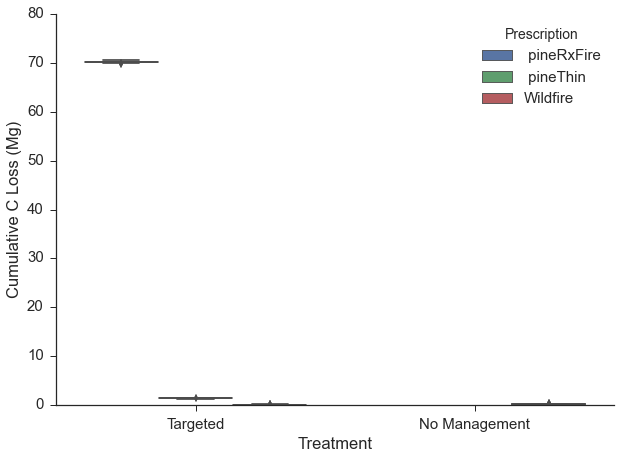

In [524]:
ECloss = allClosses[allClosses.FW == 'Extreme']
CCloss = allClosses[allClosses.FW == 'Contemporary']

f, (ax1) = plt.subplots(1,1, figsize =(10,7))
fig = sns.boxplot(x = 'simname', y = 'MgBiomassRemoved', hue = 'Prescription', data =CCloss)

sns.set_context('notebook', font_scale=1.5)

ax1.set_ylabel('Cumulative C Loss (Mg)')
ax1.set_xlabel('Treatment')

sns.despine()
plt.savefig('CLosses.tif')